In [88]:
import numpy as np
import matplotlib.pyplot as pl

import torch
from masking import *

import csv

from latencies import *
from utils.temchinData import data_temchin2008

from rbf import RBFNet

In [89]:
fs=48828


#depends on expe:
I0 = 100 +10 - 32 #intensity ref for masker    #100 dB rms=1  +10 dB amp 5   (/sqrt(2))   #-32 dB masker atten
I0 = 10*np.log10( 10**(I0/10)/(fs/2) ) #spectral density

#Note for later: import common script to analysis instead?

### First estimation Q10 

In [90]:
def lin_reg(x, y):
    x0=np.mean(x)
    y0=np.mean(y)
    x2=x-x0
    y2=y-y0
    
    a=np.mean(x2*y2)/np.mean(x2**2)
    
    b=y0-a*x0
    return a,b

In [91]:

freqs_t=np.array(data_temchin2008[::2])
freqs_t=10**freqs_t
q10_t=np.array(data_temchin2008[1::2])



In [92]:
bf_anf=[]
q10_anf=[]
with open('results/q101-22/q10s_clean.csv', 'r') as f:
    reader=csv.DictReader(f)
    for row in reader:
        bf_anf.append(float(row['CF'])*1e3)
        
        q10_anf.append(float(row['Q10']))
        

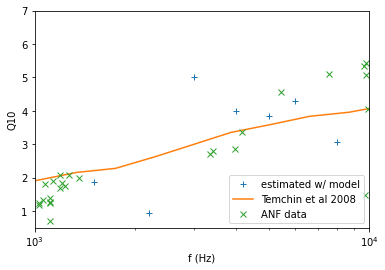

In [93]:
freqs=np.array([1.5, 2.2, 3, 4, 5, 6, 8])*1e3
bw10=np.array([800, 2300, 600, 1000, 1300, 1400, 2600])
bw10_C=np.array([850,2400,850,1000,1250,2200,2500])


bw10_R=np.array([850,1450,350,1000,1250,950,2950])

pl.plot(freqs, freqs/bw10, '+', label='estimated w/ model')

pl.plot(freqs_t, q10_t, label='Temchin et al 2008')
pl.xlim([1000, 10000])
#pl.plot(freqs, freqs/bw10_C, '+', label='C')

#pl.plot(freqs, freqs/bw10_R, '+', label='R')

#pl.legend()

#lin reg
a_t, b_t = lin_reg(np.log(freqs_t), np.log(q10_t) )
a, b = lin_reg(np.log(freqs), np.log(freqs/bw10) )

f=np.linspace(1000, 10000)


#pl.plot(f, np.exp(b_t)*f**a_t)
#pl.plot(f, np.exp(b)*f**a)


pl.plot(bf_anf, q10_anf, 'x', label='ANF data')

pl.xscale('log')

pl.xlabel('f (Hz)')
pl.ylabel('Q10')
pl.legend(loc='lower right')
#pl.savefig('q10_estim.png')

pl.ylim([0.5, 7])
pl.show()

#pl.yscale('log')

### Estimations with optim

#### I/O funcs

In [94]:
expe_name='1-22'  #'1-22'
Q10_distributed=True
E0_distributed=True #not used as results for E0 saved in same files either way
I0_distributed=True
CFs=[2200, 3000, 4000, 5000, 6000, 8000]


results_name='test-0607c'
if results_name != '':
    results_folder=f'./results/fit{expe_name}-{results_name}/'
else:
    if Q10_distributed:
        results_folder=f'./results/fit{expe_name}-distrib/'
    else:
        results_folder=f'./results/fit{expe_name}/'
    
print(f'using as results folder: {results_folder}')
CF=6000

using as results folder: ./results/fit1-22-test-0607c/


In [95]:
wb_cdf=WeibullCDF_IOFunc.load_from_npz(f'{results_folder}/wbcfdIO_1st_estim_{CF}.npz')
wb_cdf2=WeibullCDF_IOFunc.load_from_npz(f'{results_folder}/wbcfdIO_{CF}.npz')

In [96]:
with np.load(f'{results_folder}/maskamountCAP_{CF}.npz') as data:
    I_pts=data['I_pts']
    maskamount=data['maskamount']
    


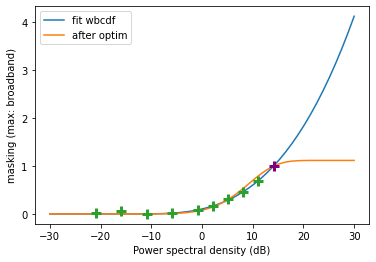

In [97]:
I=np.linspace(-30, 30)


#pl.plot(I, sigm(torch.tensor(I)), label='fit sigm')
pl.plot(I, wb_cdf(torch.tensor(I)), label='fit wbcdf')

ma=wb_cdf2(torch.tensor(I))
if len(ma.shape)>1:
    ma=torch.squeeze(ma,0)
pl.plot(I, ma, label='after optim')
pl.xlabel('Power spectral density (dB)')

pl.plot(I_pts, maskamount, '+', markersize=10, markeredgewidth=3)

pl.plot(wb_cdf2._Iref, 1, '+', markersize=10, markeredgewidth=3, color='purple')

pl.ylabel('masking (max: broadband)')
pl.legend()

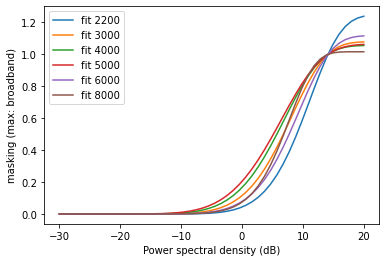

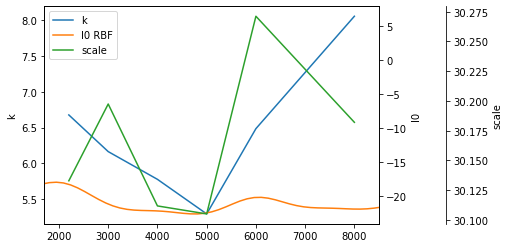

In [98]:
I=np.linspace(-30, 20)

ks=[]
I0s=[]
scales=[]
for CF in CFs:
    wb_cdf=WeibullCDF_IOFunc.load_from_npz(f'{results_folder}/wbcfdIO_{CF}.npz')
    ks.append(wb_cdf.k)
    I0s.append(wb_cdf.I0)
    scales.append(wb_cdf.scale)
    ma= wb_cdf(torch.tensor(I))
    if len(ma.shape)>1:
        ma=torch.squeeze(ma,0)
    pl.plot(I, ma, label=f'fit {CF}')
    
pl.xlabel('Power spectral density (dB)')

pl.ylabel('masking (max: broadband)')
pl.legend()

pl.show()


fig=pl.figure()
ax=pl.gca()

p1, = pl.plot(CFs, ks, label='k', color='C0')

pl.ylabel('k')

ax.twinx()
if I0_distributed:
    
    with np.load(f'{results_folder}/I0_from_RBF.npz') as data:
        p2, = pl.plot(data['f'], data['I0'], label=f'I0 RBF', color='C1')

else:
    p2, = pl.plot(CFs, np.array(I0s), label='I0', color='C1')
    
pl.ylabel('I0')

ax2=ax.twinx()
p3, = pl.plot(CFs, scales, label='scale', color='C2')
ax2.spines["right"].set_position(("axes", 1.2))

pl.xlabel('CF (Hz)')
pl.ylabel('scale')

lines = [p1, p2, p3]
ax.legend(lines, [l.get_label() for l in lines])

pl.xlim([CFs[0]-500, CFs[-1]+500])
pl.show()

In [99]:
k_func = lambda f: np.interp(f, np.array(CFs), np.array(ks))
#k_func = lambda f: ks[-1]

if I0_distributed:
    '''net_I0=RBFNet.create_from_jsonfile(f'{results_folder}/RBF_I0_params.json')
    with np.load(f'{results_folder}/I0_RBF_weights.npz') as data:
        rbf_weights=data['weights']
    net_I0.l2.weight.data=torch.tensor(rbf_weights)
    I0_func=net_I0
    ''' #issues with tensor format/numpy
    
    with np.load(f'{results_folder}/I0_from_RBF.npz') as data:
        RBF_f=data['f']
        RBF_I0=data['I0']
    I0_func = lambda f: np.interp(f, RBF_f, RBF_I0)
    
else:
    I0_func = lambda f: np.interp(f, np.array(CFs), np.array(I0s))
scale_func = lambda f: np.interp(f, np.array(CFs), np.array(scales))
#scale_func=lambda f: np.array(scales)[-1]
Iref=wb_cdf._Iref
constrained_at_Iref=wb_cdf.constrained_at_Iref

f_lin, level_lin, isomaskcurves=isomasking_curves_wbcdf(CFs[0]-500., CFs[-1]+1000., 20, 10, I0_func, scale_func, k_func,
            constrained_at_Iref=constrained_at_Iref, Iref=Iref, eps=0.001)



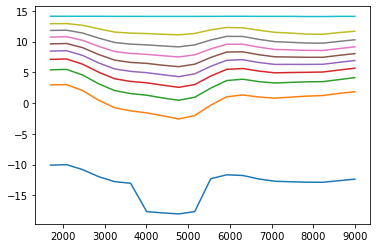

In [100]:
pl.plot(f_lin, isomaskcurves.T)

#### E0

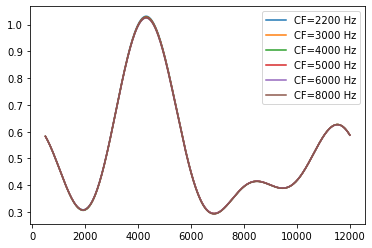

In [101]:
for CF in CFs: #8000
    with np.load(f'{results_folder}/E0_{CF}.npz') as data:
        f=data['f']
        E0=data['E0']
        E0_amp=data['E0_amp']
        f=np.linspace(f[0], f[-1], len(E0)) #HACK err for now
        pl.plot(f, E0, label=f"CF={CF} Hz")
pl.legend()
pl.show()

Latencies

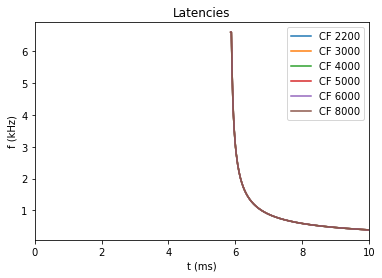

In [102]:
ax=None
for CF in CFs: #8000
    lat_model=PowerLawLatencies.load_from_npz(f'{results_folder}/lat_{CF}.npz')
    lat_model.name=f'CF {CF}'
    ax=plotLatencies(lat_model, ax=ax)

Equivalent E0 in time

$w'(\tau) d\tau = w(f) A \alpha \tau^{\alpha-1} df$

Text(0.5, 0, 't (ms)')

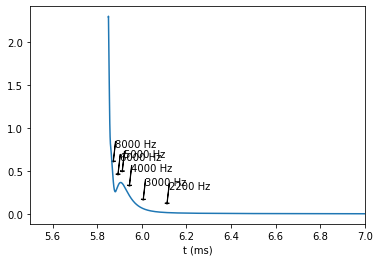

In [103]:
t=lat_model.t_from_f(f).detach().numpy()
A=lat_model.A.detach().numpy()
alpha=lat_model.alpha.detach().numpy()
t0=lat_model.t0.detach().numpy()
w=E0*A*alpha*np.power(np.abs(t-t0), alpha-1)
w=np.abs(w)


pl.plot(t*1e3, w*1e-8)
pl.xlim([5.5, 7])

for CF in CFs:
    t_CF=lat_model.t_from_f(CF).detach().numpy()
    ind=int((CF-f[0])/f[-1]*len(E0))
    w_CF=E0[ind]*A*alpha*np.power(np.abs(t_CF-t0), alpha-1)
    w_CF=np.abs(w_CF)
    dx=0.01
    dy=0.1*np.amax(w*1e-8)
    pl.arrow(t_CF*1e3+1.5*dx, w_CF*1e-8+1.5*dy, -dx, -dy, head_width=0.02, head_length=0.01,
             fc='k', ec='k', head_starts_at_zero=True)
    pl.text(t_CF*1e3+1.2*dx, w_CF*1e-8+1.2*dy, f'{CF} Hz')
pl.xlabel('t (ms)')
#pl.ylim([0,1])

#### Unitary responses

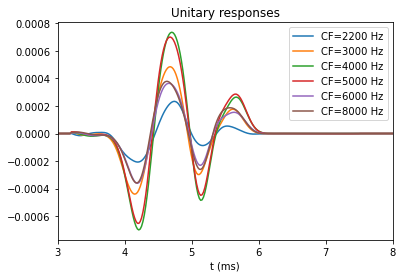

In [104]:

for CF in CFs:
    with np.load(f'{results_folder}/ur_{CF}.npz') as data:
        ur=data['ur']
        t2=data['t2']
        pl.plot(t2*1e3, ur, label=f"CF={CF} Hz")
        pl.xlim([3,8])
pl.xlabel('t (ms)')
pl.title('Unitary responses')
pl.legend()
pl.show()

corrected by E_amp

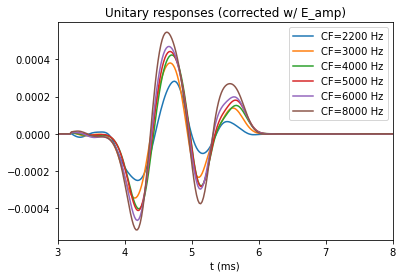

In [105]:

for CF in CFs:
    with np.load(f'{results_folder}/ur_{CF}.npz') as data:
        ur=data['ur']
        t2=data['t2']

    with np.load(f'{results_folder}/E0_{CF}.npz') as data:
        #f=data['f']
        #E0=data['E0']
        E0_amp=data['E0_amp']
        
    pl.plot(t2*1e3, E0_amp*ur, label=f"CF={CF} Hz")
    pl.xlim([3,8])
pl.xlabel('t (ms)')
pl.title('Unitary responses (corrected w/ E_amp)')
pl.legend()
pl.show()

normalized re:max

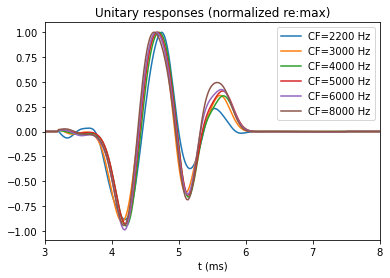

In [106]:

for CF in CFs:
    with np.load(f'{results_folder}/ur_{CF}.npz') as data:
        ur=data['ur']
        t2=data['t2']
        pl.plot(t2*1e3, ur/np.amax(np.abs(ur)), label=f"CF={CF} Hz")
        pl.xlim([3,8])
pl.xlabel('t (ms)')
pl.title('Unitary responses (normalized re:max)')
pl.legend()
pl.show()

#### Q10

#TODO single values

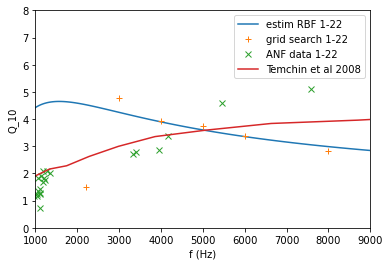

In [107]:
if Q10_distributed:
    with np.load(f'{results_folder}/Q10.npz') as data:
        pl.plot(data['f'], data['Q10'], label=f'estim RBF {expe_name}')
        pl.ylabel('Q_10')
        pl.xlabel('f (Hz)')
        pl.xlim([1000, 9000])
        pl.ylim([0,8])

q10_gridsearch=[]
for CF in CFs:
    with np.load(f'{results_folder}/Q10gridsearch_{CF}.npz') as data:
        q10_gridsearch.append(CF/data['bw10_est'])
pl.plot(CFs, q10_gridsearch, '+', label=f'grid search {expe_name}')
        
pl.plot(bf_anf, q10_anf, 'x', label='ANF data 1-22')

pl.plot(freqs_t, q10_t, label='Temchin et al 2008')
pl.legend()

####  Errors

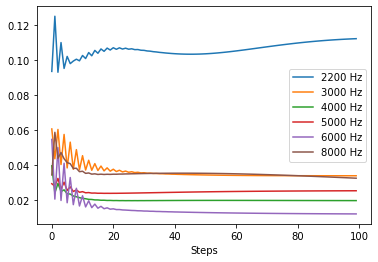

In [108]:

for CF in CFs:
    err= np.load(f'{results_folder}/err_list_{CF}.npy', allow_pickle=True)
    pl.plot(err, label=f'{CF} Hz')
#pl.ylim([0.001, 0.006])
pl.xlabel('Steps')
pl.legend()